## ResNet
随着设计的网络越来越深,理解新添加的层如何提升性能越发重要,更重要的是网络设计能力.

### 函数类
假设有一个神经网络架构F,包括了lr和其他参数,对于所有的f属于F,存在一些参数集合,包含了权重和偏置,这些参数可以在核实的数据集上进行训练而获得.假设$f*$是我们想要的函数,而且$f*$属于F,那我们可以很容易的训练得到他,但是通常不会这么容易.相反 我们尝试找到一个函数$f*F$这是在F中的最佳选择.
例如给定一个具有X特征和y标签的数据集,我们可以尝试通过解决以下问题来找到想要的f\
![](img/2022-04-28-14-18-52.png)\
那么.如何获得更接近真实的$f*$呢,唯一合理的可能性是,设计一个更加强大的网络架构$F'$,但是实际上新设计的网络架构可能比原来更弱\
![](img/2022-04-28-14-24-54.png)

只有当较为复杂的函数类包含较小的函数类的时候,我们才能确保提高他们的性能.对于深度神经网络.如果我们能将新添加的层训练成恒等映射(indentity function) f(x)=x,新模型和原模型将同样有效.同时 由于新模型可能得出更优的解来拟合训练数据集,因此添加层似乎更容易降低训练误差.

针对这一问题,ResNet被提出,核心思想:
**每个附加层都应该更容易的包含原始函数作为其元素之一.**
因此残差块(residual block)便产生了,这个设计对如何建立深层神经网络产生了深远的影响.

### Residual Block 残差块

focus on the internal of the network, as the shown of the figur7.6.2,suppose that the original input of net is $x$,但是我们想要学出来的理想的映射为f(x),作为activation function的输入, 在左图的虚线框中的部分需要直接拟合出想要的映射f(x),而右图的虚线框部分则需要拟合残差映射$f(x)-x$,在实际中,残差映射更容易拟合和优化.
本节开头我们希望学出理想的映射f(x),我们只需要将右图的虚线框内上方的加权运算(如仿射)的权重和偏置参数设置成0,那么f(x)即为恒等映射,实际中,当理想的映射极其接近恒等映射时,残差映射也易于捕捉恒定映射的细微波动.
右图即残差块,在RB(residual block)中,输入可以通过跨层数据线路更快地前向传播

![](img/2022-04-28-14-36-38.png)

ResNet 沿用了VGG完整的3X3卷积层设计.在RB中首先有两个相同输出通道的3X3卷积层.每个卷积层后接一个BN(BatchNormal)层和ReLU.
然后我们通过跨层数据通路 跳过这两个卷积运算,将输入直接加在最后的ReLU激活函数前,这样的设计要求两个卷积层的输出与输入形状相同.从而使他们可以相加.
如果想改变通道数,就需要引入一个额外的1X1卷积块,
RB实现如下:

In [1]:
import torch
from torch import nn as nn
from torch.nn import functional as F
import sys 
import os
sys.path.append(os.path.abspath('../'))
import lmy
from icecream import ic

In [2]:
class Residual(nn.Module):

    def __init__(self, in_channels, num_channels, use_1x1conv=False, strides=1):
        """残差块的初始化

        Args:
            in_channels (int): 输入的通道数
            num_channels (int): 输出的最终通道数
            use_1x1conv (bool, optional): 是否要使用1x1的卷积来实现通道数的变换. Defaults to False.
            strides (int, optional): 步长. Defaults to 1.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, num_channels,
                               kernel_size=3, stride=strides, padding=1)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(
                in_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = self.conv1(X)
        Y = self.bn1(Y)
        Y = F.relu(Y)
        Y = self.conv2(Y)
        Y = self.bn2(Y)
        if self.conv3:
            X = self.conv3(X)

        Y += X
        return F.relu(Y)


残差块如下图
![](img/2022-04-28-14-56-13.png)

In [3]:
# 输出和输入形状一致的情况
block1 = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
X.shape
Y = block1(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [4]:
# 输出和输入形状不一致的情况
block2 = Residual(3, 6, use_1x1conv=True, strides=2)
X = torch.rand(4, 3, 6, 6)
Y = block2(X)

### ResNet模型
![](img/2022-04-29-16-24-23.png)

ResNet的前两层与GoogLeNet相同 :在输出通道数为64,步幅为2的7x7卷积后接上步幅为2的3x3MaxPooling,不同之处在于ResNet每个卷积层后增加了BN层 \

In [5]:
b1 = nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)
# X = torch.ones((2,1,224,224))
# for layer in b1:
#     X = layer(X)
#     print(layer.__class__.__name__,f"{X.shape}")

GNet在后面接了四个Inception块,而ResNet字啊后面使用了四个残差块组成的模块ResidualNet,每个模块使用若干个同样输出通道数的残差块

In [6]:
def resnet_block(in_channels,num_channels,num_residuals,first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(in_channels,num_channels,use_1x1conv=True,strides=2))
        else: 
            blk.append(Residual(num_channels,num_channels))
    return blk

In [7]:
b2 = nn.Sequential(*resnet_block(64,64,2,first_block=True))
b3 = nn.Sequential(*resnet_block(64,128,2))
b4 = nn.Sequential(*resnet_block(128,256,2))
b5 = nn.Sequential(*resnet_block(256,512,2))
resNet = nn.Sequential(b1,b2,b3,b4,b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(),nn.Linear(512,10))

In [8]:
X = torch.randn((1,1,224,224))
for layer in resNet:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:', X.shape)

Sequential output shape: torch.Size([1, 64, 56, 56])
Sequential output shape: torch.Size([1, 64, 56, 56])
Sequential output shape: torch.Size([1, 128, 28, 28])
Sequential output shape: torch.Size([1, 256, 14, 14])
Sequential output shape: torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape: torch.Size([1, 512, 1, 1])
Flatten output shape: torch.Size([1, 512])
Linear output shape: torch.Size([1, 10])


FashionMNIST数据集加载成功，训练集大小:60000,测试集大小:10000,数据集shape:torch.Size([1, 28, 28])
[device(type='cuda', index=0), device(type='cuda', index=3)]
设备数量不足,已自动调整
训练设备[device(type='cuda', index=0), device(type='cuda', index=3)]


  0%|          | 0/10 [00:06<?, ?epoch/s]


RuntimeError: NCCL Error 2: unhandled system error

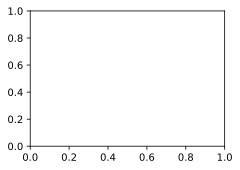

In [9]:
lr , num_epochs ,batch_size = .05,10,256
train_iter,test_iter = lmy.loadFashionMnistData(batch_size)
lmy.train_GPU(resNet,train_iter,test_iter,num_epochs,lr,num_devices=3)